<a href="https://colab.research.google.com/github/Pokemon-Catcher/pandasHomework/blob/master/Copy_of_03_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Рекомендательная система (20 баллов)

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

В этой практике мы попробуем построить очень простую рекомендательную систему, основанную на поиске кластера похожих пользователей.  
Похожие они в том плане, что смотрят одинаковые фильмы и оценивают их приблизительно одинаково.  
Мы будем строить очень простую модель, по сути которая даже не является именно системой рекомендации, но как минимум она может быть первым шагом к ее построению: мы найдем класет похожих пользователей, узнаем какие фильмы они смотрят и одинаково любят, какие жанры предпочитают.

Лабораторная будет больше похожа на манипулции с одним большим датафреймом. Если у вас появятся интересные идеи, то можете попробовать их тоже. 

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [0]:
import pandas as pd
import numpy as np

In [2]:
colab = True
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
if colab:
    anime = pd.read_csv('/content/drive/My Drive/Data/anime/anime.csv.zip', index_col='anime_id')
else:
    anime = pd.read_csv('../../data/anime/anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
if colab:
    ratings = pd.read_csv('/content/drive/My Drive/Data/anime/rating.csv.zip')
else:
    ratings = pd.read_csv('../../data/anime/rating.csv.zip')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Обзор данных (1 балл)

Постройте графики для обзора признаков: anime.type, episodes, rating, members.

Посмотрите на info по таблицам, нам важно знать сколько оперативной памяти занимает каждая таблица, так как дальше у нас будет декартово произведение таблиц и размер может вылететь за 5 гигабайт.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 32281 to 26081
Data columns (total 6 columns):
name        12017 non-null object
genre       12017 non-null object
type        12017 non-null object
episodes    12017 non-null object
rating      12017 non-null float64
members     12017 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 657.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
user_id     int64
anime_id    int64
rating      int64
dtypes: int64(3)
memory usage: 178.8 MB
Anime with unknown episodes:  187


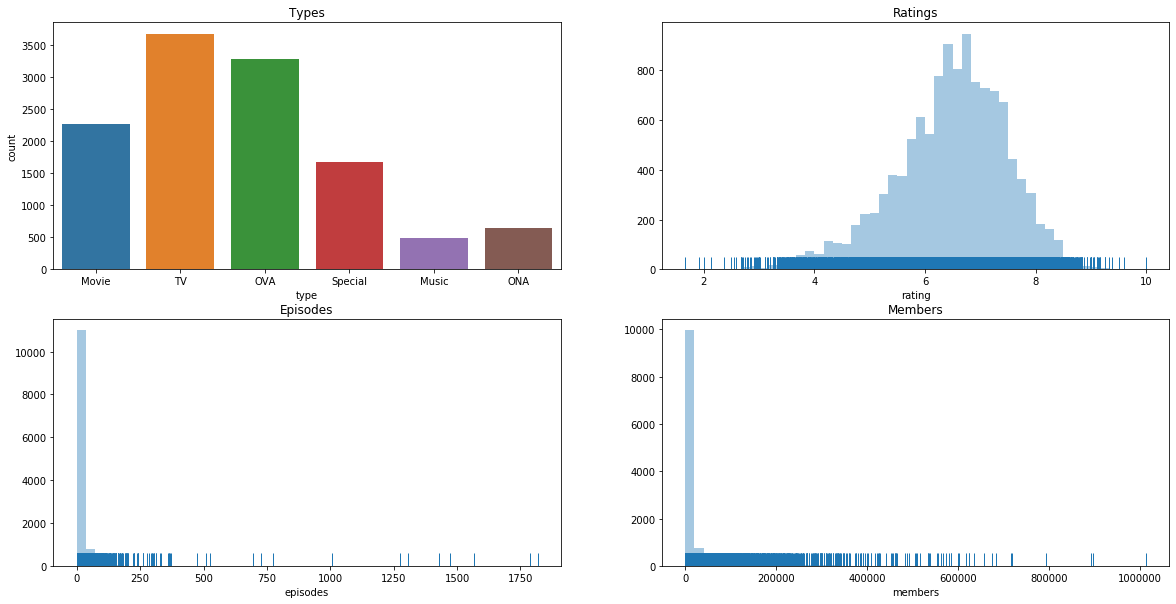

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

anime.info()
ratings.info()

fig=plt.figure(figsize=(20,10))
axs = fig.subplots(2, 2)

unknown_episodes=anime[anime.episodes=='Unknown']
episodes=anime.episodes.apply(lambda x: int(x) if x!='Unknown' else -1)
sns.countplot(x='type',data=anime, ax=axs[0, 0])
axs[0,0].set_title('Types')
sns.distplot(a=episodes, bins=50,kde=False, rug=True,ax=axs[1, 0])
axs[1,0].set_title('Episodes')
sns.distplot(a=anime['rating'], bins=50,kde=False, rug=True,ax=axs[0, 1])
axs[0,1].set_title('Ratings')
sns.distplot(a=anime['members'], bins=50,kde=False, rug=True,ax=axs[1, 1])
axs[1,1].set_title('Members')
print('Anime with unknown episodes: ', len(unknown_episodes.index))

## Жанры (4 балла)

Как в материалах к воркшопу постройте таблицу, в которой в строках будет названиефильма, а в столбцах жанр. В ячейках 1 - если в этого фильма есть такой жанр и 0 иначе.

Постройте countplot для визуализации количества фильмов каждого из жанров.

Постройте график, на котором будут изображениы распределения рейтингов по каждому из жанров. Должно получиться что-то подобное: ![Imgur](https://i.imgur.com/hyuA6ia.png)

In [19]:
import itertools

split_genres=anime['genre'].apply(lambda x: x.split(', '))
genres_list=pd.unique(list(itertools.chain.from_iterable(split_genres)))
table=pd.DataFrame(columns=genres_list)
for id, genres in split_genres.iteritems():
  for genre in genres_list:
    table.at[anime.at[id,'name'], genre]=int(genre in genres)
table

,Drama,Romance,School,Supernatural,Action,Adventure,Fantasy,Magic,Military,Shounen,Comedy,Historical,Parody,Samurai,Sci-Fi,Thriller,Sports,Super Power,Space,Slice of Life,Mecha,Music,Mystery,Seinen,Martial Arts,Vampire,Shoujo,Horror,Police,Psychological,Demons,Ecchi,Josei,Shounen Ai,Game,Dementia,Harem,Cars,Kids,Shoujo Ai,Hentai,Yaoi,Yuri
Kimi no Na wa.,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Fullmetal Alchemist: Brotherhood,1,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Gintama°,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Steins;Gate,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Gintama&#039;,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Toushindai My Lover: Minami tai Mecha-Minami,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Under World,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Violence Gekiga David no Hoshi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Violence Gekiga Shin David no Hoshi: Inma Densetsu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


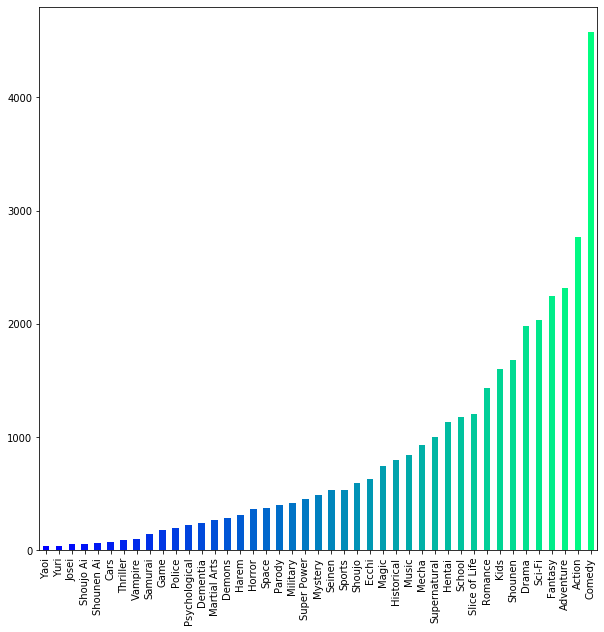

In [0]:
color = plt.cm.winter(np.linspace(0, 1,len(table.columns)))

plt.figure(figsize=(10,10))
table.sum().sort_values().plot(kind="bar",color=color)

Text(0, 0.5, 'Density')

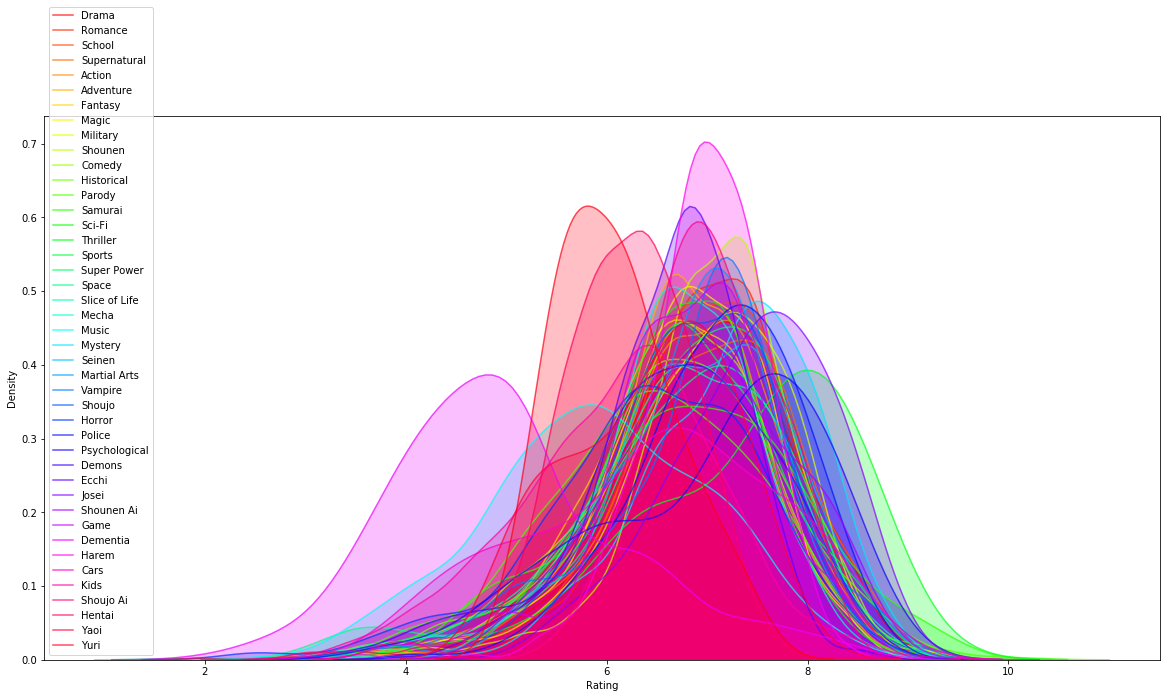

In [0]:
rating_genre=table.join(anime.set_index('name').rating)

plt.figure(figsize=(20,10))
color = plt.cm.hsv(np.linspace(0, 1,len(genres_list)))
for index, i in zip(range(len(genres_list)),genres_list):
  d=rating_genre.loc[:,[i,'rating']]
  d=d[d[i]==1].rating
  sns.kdeplot(d,shade=True,color=[color[index][0],color[index][1],color[index][2],0.7], Label=i)
plt.xlabel('Rating') 
plt.ylabel('Density') 

##[] Рейтинг (1 балл)

Постройте график, показывающий сколько оценок каждого рейтинга поставили пользователи из таблицы `ratings`.

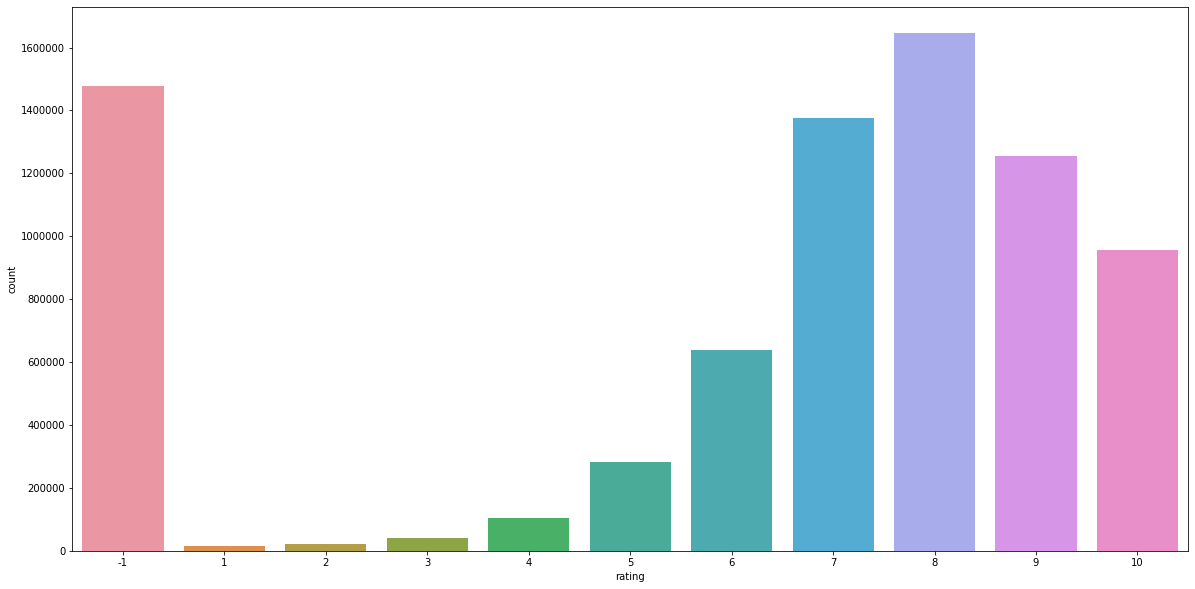

In [0]:
fig=plt.figure(figsize=(20,10))
sns.countplot(x='rating',data=ratings)

## Фильтрация данных (5 баллов)

Если мы сразу же построим кросстаб матрицу `anime` vs `user`, где в ячейках рейтинг, который поставил юзер этому фильму, то у нас это все займет около 6 гигабайт памяти. Можно значительно сократить размер матрицы, если выкинуть данные об аниме, которое почти никто не оценил и юзеров, которые почти ничего не оценивали.

Для этого постройте два новых датафрейма:

- anime_watches, где индексом является anime_name, а значением - количество его обзоров
- user_ratings, где индексом является user_id, а значением - количество вниме, которое он оценил.

Далее, соедините (join) 4 таблицы: ratings, anime, anime_watches, user_ratings и назовите новую таблицу anime_ratings.

Что означает `-1` в таблице рейтинга? Замените все -1 на средний рейтинг аниме.

Удалите из таблицы все те значения, у которых количество обзоров и рейтингов меньше медианного значения. То есть мы удалим половину аниме и половину юзеров.

In [6]:
ratings_count=ratings.groupby('anime_id').count()['user_id'].rename('watches')


anime_watches=pd.Series(data=anime.join(ratings_count).set_index('name')['watches'])
display(anime_watches)

user_ratings=ratings.groupby('user_id').apply(lambda x: len(x['anime_id']))
display(user_ratings)

name
Kimi no Na wa.                                         2199.0
Fullmetal Alchemist: Brotherhood                      24574.0
Gintama°                                               1386.0
Steins;Gate                                           19283.0
Gintama&#039;                                          3673.0
                                                       ...   
Toushindai My Lover: Minami tai Mecha-Minami              4.0
Under World                                               4.0
Violence Gekiga David no Hoshi                            3.0
Violence Gekiga Shin David no Hoshi: Inma Densetsu        4.0
Yasuji no Pornorama: Yacchimae!!                          2.0
Name: watches, Length: 12017, dtype: float64

user_id
1        153
2          3
3         94
4         52
5        467
        ... 
73512     13
73513     33
73514      1
73515    196
73516      2
Length: 73515, dtype: int64

In [7]:

anime.index.names = ['anime_id']
anime_ratings=ratings.join(anime, rsuffix='_avg',on='anime_id').join(anime_watches, on='name').join(user_ratings.rename("count"),on='user_id')
anime_ratings = anime_ratings[~anime_ratings.index.duplicated()]
unseen=anime_ratings['rating']!=-1
anime_ratings.loc[:,'rating']=anime_ratings['rating'].where(unseen,anime_ratings['rating_avg'].values)
anime_ratings


,user_id,anime_id,rating,name,genre,type,episodes,rating_avg,members,watches,count
0,1,20,7.81,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0,25925.0,153
1,1,24,8.06,School Rumble,"Comedy, Romance, School, Shounen",TV,26,8.06,178553.0,7153.0,153
2,1,79,7.31,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24,7.31,158772.0,7112.0,153
3,1,226,7.85,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511.0,27506.0,153
4,1,241,6.69,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11,6.69,84395.0,4180.0,153
...,...,...,...,...,...,...,...,...,...,...,...
7813732,73515,16512,7.00,Devil Survivor 2 The Animation,"Action, Demons, Supernatural",TV,13,7.06,101266.0,3504.0,196
7813733,73515,17187,9.00,Ghost in the Shell: Arise - Border:1 Ghost Pain,"Mecha, Police, Psychological, Sci-Fi",Movie,1,7.64,31747.0,1154.0,196
7813734,73515,22145,10.00,Kuroshitsuji: Book of Circus,"Comedy, Demons, Fantasy, Historical, Shounen, ...",TV,10,8.37,122895.0,3544.0,196
7813735,73516,790,9.00,Ergo Proxy,"Mystery, Psychological, Sci-Fi",TV,23,8.03,265005.0,7736.0,2


In [8]:
dropped=(anime_ratings['watches']<anime_ratings.watches.mean()) | (anime_ratings['count']<anime_ratings['count'].mean())
anime_ratings_dropped=anime_ratings[~dropped]
anime_ratings_dropped

,user_id,anime_id,rating,name,genre,type,episodes,rating_avg,members,watches,count
302,5,6,8.0,Trigun,"Action, Comedy, Sci-Fi",TV,26,8.32,283069.0,11077.0,467
306,5,20,6.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0,25925.0,467
308,5,24,1.0,School Rumble,"Comedy, Romance, School, Shounen",TV,26,8.06,178553.0,7153.0,467
309,5,30,1.0,Neon Genesis Evangelion,"Action, Dementia, Drama, Mecha, Psychological,...",TV,26,8.32,461946.0,17686.0,467
310,5,45,7.0,Rurouni Kenshin: Meiji Kenkaku Romantan,"Action, Adventure, Comedy, Historical, Romance...",TV,94,8.43,218928.0,7900.0,467
...,...,...,...,...,...,...,...,...,...,...,...
7812664,73502,15809,9.0,Hataraku Maou-sama!,"Comedy, Demons, Fantasy, Romance, Shounen",TV,13,8.03,409037.0,14370.0,510
7812677,73502,16498,10.0,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229.0,29584.0,510
7812679,73502,16592,7.0,Danganronpa: Kibou no Gakuen to Zetsubou no Ko...,"Action, Horror, Mystery, Psychological",TV,13,7.49,298550.0,10082.0,510
7812682,73502,16742,9.0,Watashi ga Motenai no wa Dou Kangaetemo Omaera...,"Comedy, School, Shounen, Slice of Life",TV,12,7.29,257925.0,8244.0,510


## Матрица user-item (3 балла)

Превратите таблицу anime_ratings в матрицу, где в строках user_id, в стобцах anime_name, а в ячейках рейтинг. Посмотрите сколько заним**а**ет в памяти эта матрица.

In [9]:
user_item=pd.pivot_table(anime_ratings_dropped, 'rating', 'user_id', 'name',aggfunc=np.int8, fill_value=np.int8(0))
print('Memory usage is ', (user_item.memory_usage().sum())/1024/1024, 'mb')
user_item.reset_index().set_index('user_id')
user_item

Memory usage is  9.222030639648438 mb


name,Accel World,Air,Air Gear,Akame ga Kill!,Akira,Aldnoah.Zero,Amagi Brilliant Park,Angel Beats!,Angel Beats!: Another Epilogue,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,Another,Ao Haru Ride,Ao no Exorcist,Azumanga Daioh,B Gata H Kei,Baccano!,Baka to Test to Shoukanjuu,Baka to Test to Shoukanjuu Ni!,Bakemonogatari,Bakuman.,Barakamon,Berserk,Bishoujo Senshi Sailor Moon,Black Bullet,Black Lagoon,Black Lagoon: The Second Barrage,Black★Rock Shooter (OVA),Black★Rock Shooter (TV),Bleach,Bleach Movie 1: Memories of Nobody,Bleach Movie 2: The DiamondDust Rebellion - Mou Hitotsu no Hyourinmaru,Bleach Movie 3: Fade to Black - Kimi no Na wo Yobu,Blood Lad,Blood+,Boku dake ga Inai Machi,Boku wa Tomodachi ga Sukunai,Boku wa Tomodachi ga Sukunai Next,Btooom!,Byousoku 5 Centimeter,Cardcaptor Sakura,...,Sora no Otoshimono,Sora no Otoshimono: Forte,Soul Eater,Special A,Steins;Gate,Steins;Gate: Oukoubakko no Poriomania,Sukitte Ii na yo.,Summer Wars,Suzumiya Haruhi no Shoushitsu,Suzumiya Haruhi no Yuuutsu,Suzumiya Haruhi no Yuuutsu (2009),Sword Art Online,Sword Art Online II,Tengen Toppa Gurren Lagann,Tenkuu no Shiro Laputa,To LOVE-Ru,Toaru Kagaku no Railgun,Toaru Majutsu no Index,Toaru Majutsu no Index II,Toki wo Kakeru Shoujo,Tokyo Ghoul,Tokyo Ghoul √A,Tonari no Kaibutsu-kun,Tonari no Totoro,Toradora!,Trigun,Usagi Drop,Vampire Knight,Vampire Knight Guilty,Watashi ga Motenai no wa Dou Kangaetemo Omaera ga Warui!,Working!!,Yahari Ore no Seishun Love Comedy wa Machigatteiru.,"Yosuga no Sora: In Solitude, Where We Are Least Alone.",Yuu☆Yuu☆Hakusho,Zankyou no Terror,Zero no Tsukaima,Zero no Tsukaima F,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo,Zetsuen no Tempest
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,3,0,0,4,8,0,6,3,0,7,0,0,4,0,2,0,1,1,8,5,8,0,0,3,0,0,0,0,3,0,0,0,7,2,0,7,3,0,7,3,...,2,1,5,0,9,8,0,6,0,0,0,1,0,0,0,2,0,6,0,8,2,2,2,0,3,8,7,0,0,5,2,3,0,7,0,1,1,1,1,0
7,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,8,0,9,8,7,0,0,8,...,8,7,0,0,0,0,0,0,0,7,4,8,6,0,0,7,7,9,9,0,0,0,0,0,0,0,0,0,0,6,7,0,7,0,0,0,0,0,0,0
17,0,0,0,6,8,7,8,9,7,8,8,7,0,6,0,9,7,0,8,0,8,0,0,5,8,0,5,0,0,0,0,0,7,0,8,6,6,0,9,0,...,0,0,0,0,10,8,0,8,9,7,5,7,8,10,0,7,8,8,8,8,7,4,0,0,7,7,0,0,0,6,0,5,5,0,7,0,0,0,0,0
46,0,0,9,9,0,0,9,0,0,9,0,0,8,0,0,0,10,0,0,10,0,0,0,7,0,0,0,0,10,8,9,9,0,8,0,9,0,0,9,0,...,0,0,10,9,9,0,10,7,0,0,0,8,8,0,10,0,0,0,0,0,10,9,10,10,8,0,9,8,7,9,0,0,0,0,10,0,0,0,0,9
54,7,0,7,7,8,7,0,0,0,8,7,0,0,8,7,8,0,0,8,8,8,0,0,7,8,8,0,7,7,7,7,0,0,0,0,7,7,7,8,0,...,7,0,0,7,9,0,7,0,0,8,7,7,7,8,0,7,7,7,7,8,8,7,7,8,8,0,8,7,7,7,7,8,0,0,8,7,7,7,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73417,8,7,0,8,0,8,6,9,0,7,6,7,7,0,7,9,8,8,7,0,0,0,0,7,0,0,0,7,0,0,0,0,7,0,9,8,8,7,5,0,...,7,7,0,0,0,0,7,0,8,7,6,6,7,8,0,8,0,7,8,0,8,7,8,0,8,7,9,8,8,6,0,7,7,7,8,8,7,8,7,8
73457,0,0,0,0,10,7,0,10,9,0,9,0,0,0,0,10,0,0,10,0,0,7,0,0,9,9,3,9,6,6,4,6,0,7,0,0,0,0,0,0,...,0,0,0,0,10,10,0,0,0,10,0,9,0,0,5,0,6,8,6,8,0,0,0,10,10,0,0,7,6,0,0,0,2,0,0,8,0,7,0,0
73491,0,7,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,8,8,7,0,0,7,7,0,0,0,0,0,0,0,0,8,...,7,0,8,0,0,0,0,0,0,8,0,0,0,0,0,7,7,7,0,0,0,0,0,0,10,0,0,7,7,0,8,0,0,0,0,0,0,0,0,0


In [0]:
def deleteDup(x):
    if type(x) is np.ndarray:
      return x[0]
    return x
user_item2=user_item.apply(lambda x: x.apply(deleteDup))

## Понижение размерности (1 балл)

kNN будет плохо работать на многомерных данных, поэтому надо понизить размерности матрицы с помощью алгоритма PCA. Количество размерностей установите от 4 до 10 - как вам покажется оптимальнее. (можете это исправить когда запустите kNN и получите результаты).

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1)) 
pca=PCA(n_components=10)
pca_result= pca.fit_transform(scaler.fit_transform(user_item2))
pca_result

array([[-1.41910001, -2.96365198,  0.14058977, ...,  0.57252853,
         1.39940366,  0.43343517],
       [-0.94423391, -2.35897041, -1.0791859 , ..., -0.57705564,
        -0.14694063,  0.395418  ],
       [ 0.85057202, -0.21371285,  2.75029266, ..., -0.3121625 ,
        -0.21313093,  0.77522336],
       ...,
       [-3.60257789, -1.02033664, -2.18341109, ..., -0.37955264,
        -0.07753283,  0.37179985],
       [ 1.69667114,  1.89684686, -0.64277836, ...,  0.34272926,
        -0.31300226,  0.2269033 ],
       [ 1.08089627,  1.86394671, -1.56819316, ...,  1.66335778,
        -0.55276319,  0.086039  ]])

## Обучение kMeans (1 балл)

Обучим kMeans, чтобы он нашел нам центры кластеров нашей выборки.

Так как в строках у нас user_id, то центры класетров - это будут характеристики пользователей в терминах их оценок аниме. Используя эту информацию мы можем вычислить список характерных аниме для конкретного кластера.

- обучите kMeans
- создайте копию матрицы и добавьте новую колонку - кластер. Положите в нее результат предсказания кластера для каждого пользователя. (метод predict)
- нарисуйте cout plot количества юзеров в каждом кластере. Если получается сильно неравномерное распределение, то вам надо подобрать другое количество кластеров или изменить размерность в предыдущем шаге.

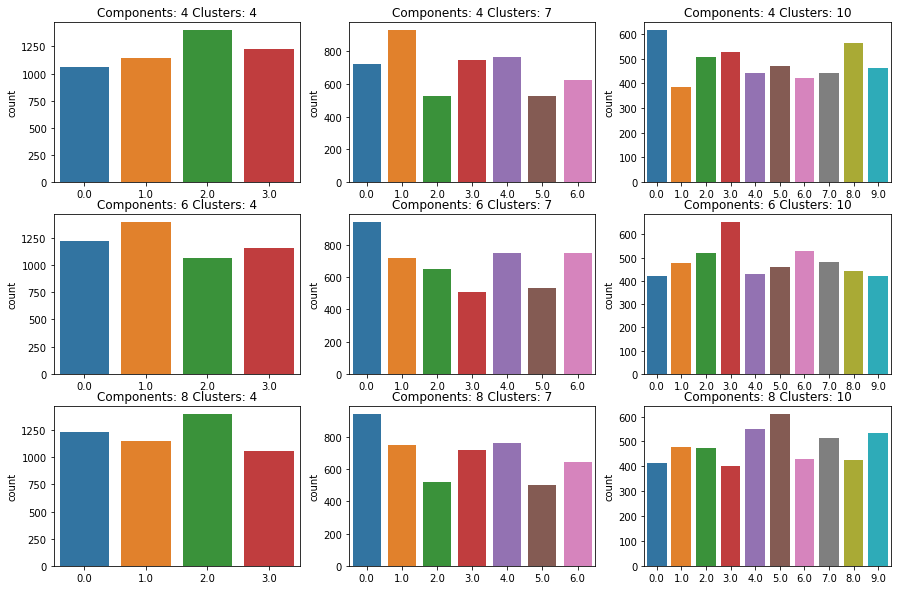

In [16]:
from sklearn.cluster import KMeans

kmean=KMeans().fit(pca_result) #обучил

copy=np.column_stack((pca_result,kmean.predict(pca_result).T)) #создал копию, используя предикт хотя особого смысла предиктить на данных с помощью которых обучался нет, можно было через labels_

def transform(pca_n,kmeans_n, data): #Здесь всё тоже самое, просто для удобства вынесено в функцию
  pca=PCA(n_components=10)
  pca_result= pca.fit_transform(scaler.fit_transform(data))
  kmean=KMeans(n_clusters=kmeans_n).fit(pca_result)
  copy=np.column_stack((pca_result,kmean.predict(pca_result).T))
  return copy
fig=plt.figure(figsize=(15,10))
axs = fig.subplots(3, 3)
results=np.empty((3,3), dtype=object)
for i in range(9):
  x=i%3
  y=int((i/3))
  n_comp=4+x*2
  n_clust=4+y*3
  results[x,y]=transform(n_comp,n_clust,user_item)
  axs[x,y].set_title('Components: {0} Clusters: {1}'.format(n_comp, n_clust))
  sns.countplot(results[x,y][:,10],ax=axs[x,y])
  

## Top 15 аниме (2 балла)

Найдем Top-15 аниме для каждого кластера. Для этого:

- найдите средний рейтинг аниме в каждом кластере. 
- для каждого кластера возьмите набор аниме с их средним рейтингом, отсортируйте этот набор по убыванию рейтинга. 
- возьмите первые 15 элементов из набора - это и будет топ15 аниме в кластере.
- согласны ли вы с содержимым кластера?

In [20]:
result=results[1,2] #Мне больше нравится этот

labeled_user=user_item.join(pd.Series(result[:,10],name='Labels', index=user_item.index))
top_anime15=labeled_user.groupby('Labels').mean().apply(lambda x: x.sort_values().tail(15),axis=1)

for i, row in top_anime15.iterrows():
  display(pd.DataFrame(row.dropna().sort_values(ascending=False)))

,0.0
Fullmetal Alchemist: Brotherhood,8.299287
Shingeki no Kyojin,8.007126
Code Geass: Hangyaku no Lelouch,7.919240
Death Note,7.881235
Code Geass: Hangyaku no Lelouch R2,7.688836
Sword Art Online,7.669834
Fullmetal Alchemist,7.144893
No Game No Life,7.142518
Ao no Exorcist,6.931116
Highschool of the Dead,6.857482


,1.0
Angel Beats!,7.838235
Toradora!,7.718487
Kore wa Zombie Desu ka?,7.327731
Clannad,7.315126
Zero no Tsukaima,7.241597
Boku wa Tomodachi ga Sukunai,7.239496
Ore no Imouto ga Konnani Kawaii Wake ga Nai,7.193277
Sword Art Online,7.153361
Baka to Test to Shoukanjuu,7.084034
Toaru Majutsu no Index,7.042017


,2.0
Steins;Gate,8.466281
Bakemonogatari,8.231214
Toradora!,8.129094
Mahou Shoujo Madoka★Magica,8.082852
Suzumiya Haruhi no Yuuutsu,8.050096
Tengen Toppa Gurren Lagann,7.857418
Code Geass: Hangyaku no Lelouch,7.809249
Angel Beats!,7.718690
Suzumiya Haruhi no Shoushitsu,7.658960
Clannad: After Story,7.647399


,3.0
No Game No Life,8.908397
Angel Beats!,8.642748
Sword Art Online,8.580153
Shingeki no Kyojin,8.479389
Sakurasou no Pet na Kanojo,8.152672
Hataraku Maou-sama!,8.106870
Toradora!,8.102290
Yahari Ore no Seishun Love Comedy wa Machigatteiru.,8.091603
Noragami,7.838168
Nisekoi,7.737405


,4.0
Code Geass: Hangyaku no Lelouch,8.390187
Code Geass: Hangyaku no Lelouch R2,7.932243
Suzumiya Haruhi no Yuuutsu,7.876168
Clannad,7.859813
Fullmetal Alchemist,7.665888
Death Note,7.642523
Elfen Lied,7.579439
Toradora!,7.572430
Angel Beats!,7.492991
Tengen Toppa Gurren Lagann,7.429907


,5.0
Death Note,6.235294
Cowboy Bebop,6.100218
Fullmetal Alchemist,6.093682
Sen to Chihiro no Kamikakushi,5.936819
Mononoke Hime,5.923747
Code Geass: Hangyaku no Lelouch,5.823529
Neon Genesis Evangelion,5.540305
Elfen Lied,5.446623
Full Metal Panic!,5.381264
Full Metal Panic? Fumoffu,5.270153


,6.0
Steins;Gate,8.881132
Code Geass: Hangyaku no Lelouch,8.805660
Code Geass: Hangyaku no Lelouch R2,8.788679
Angel Beats!,8.573585
Toradora!,8.530189
Fullmetal Alchemist: Brotherhood,8.520755
Clannad,8.294340
No Game No Life,8.258491
Clannad: After Story,8.256604
Sword Art Online,8.203774


,7.0
Sen to Chihiro no Kamikakushi,7.679167
Neon Genesis Evangelion,7.366667
Toki wo Kakeru Shoujo,7.233333
Mononoke Hime,7.200000
Cowboy Bebop,7.054167
Steins;Gate,6.993750
Howl no Ugoku Shiro,6.883333
Tengen Toppa Gurren Lagann,6.862500
Mahou Shoujo Madoka★Magica,6.787500
Suzumiya Haruhi no Yuuutsu,6.766667


,8.0
No Game No Life,7.831081
Sword Art Online,7.272523
Shingeki no Kyojin,6.880631
Angel Beats!,6.761261
Yahari Ore no Seishun Love Comedy wa Machigatteiru.,6.720721
Hataraku Maou-sama!,6.470721
Noragami,6.457207
Chuunibyou demo Koi ga Shitai!,6.412162
Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka,6.371622
Toradora!,6.364865


,9.0
Shingeki no Kyojin,8.144208
Ouran Koukou Host Club,7.463357
Death Note,7.368794
Kuroko no Basket,7.295508
Durarara!!,7.269504
Noragami,7.144208
Sen to Chihiro no Kamikakushi,7.044917
Ao no Exorcist,7.002364
Fullmetal Alchemist: Brotherhood,6.898345
Kaichou wa Maid-sama!,6.865248


## Top 5 жанров (2 балла)

Если соеднить таблицу с аниме с таблицей жанров, то можно найти топ жанров для каждого кластера. Придумайте сами как это сделать, так как тут много способов:

- найти средний рейтинг для аниме каждого жанра
- посчитать сколько представителей каждого жанра есть среди top100 аниме кластера (кстати работает лучше)
- ???

In [21]:
table #да, я выбрал не самое лучшее название для таблицы жанров

table_genre=table.loc[labeled_user.columns.drop('Labels'),:]


top_genre=pd.DataFrame(index=top_anime15.index,columns=table_genre.columns)

def getAvg(series):
  for genre in series.index:
    g=table_genre[genre]
    g=g[g==1]
    series.at[genre]=labeled_user[labeled_user.Labels==series.name][g.index].mean().mean()
  return series

mean_rating_genre=top_genre.apply(lambda x: getAvg(x), axis=1)

for i, row in mean_rating_genre.iterrows():
  display(pd.DataFrame(row.dropna().sort_values(ascending=False).head(5)))

,0.0
Game,6.003563
Police,5.697546
Military,5.535234
Super Power,5.242016
Martial Arts,5.208551


,1.0
Harem,5.740940
Ecchi,5.377954
School,4.577367
Romance,4.478072
Magic,4.387755


,2.0
Parody,6.483237
Dementia,6.172768
Josei,6.131021
Police,6.071933
Music,5.933847


,3.0
Game,7.477099
Harem,6.048044
Ecchi,5.858349
School,5.427196
Magic,5.347819


,4.0
Dementia,6.017913
Military,5.584502
Mecha,5.476636
Parody,5.226636
Samurai,5.211449


,5.0
Space,5.287582
Dementia,4.893972
Samurai,4.489107
Military,4.080610
Police,3.865650


,6.0
Game,7.017296
Police,6.498742
Josei,6.450943
Thriller,6.446918
Parody,6.327925


,7.0
Dementia,6.695833
Space,6.166667
Police,5.990972
Parody,5.295833
Thriller,5.008194


,8.0
Game,6.075075
Music,4.003003
Harem,3.922016
Ecchi,3.786106
School,3.721141


,9.0
Sports,5.746572
Shoujo,5.448857
Police,5.112687
Game,4.800236
Josei,4.581560
